Memory expects incoming queries to be (b_s, seq_len, embed_dim)     (note that queries and in fact keys, check this)

Memory returns results in (b_s, seq_len, top_k, 2, embed_dim)

In the video, the embed_dim is cut into pieces and each attn head gets a piece, so what needs to happen with the results is this:

1. Split out keys and values:
    keys: (b_s, seq_len, top_k, embed_dim)
    values: (b_s, seq_len, top_k, embed_dim)
2. Cut both in pieces to prep feeding to the attn heads:
    keys: (b_s, seq_len, top_k, heads, head_dim)
    values: (b_s, seq_len, top_k, heads, head_dim)
3. Now we need to pull the head dimension forward as we're going to feed it all into each head (except the batch):
    queries: (b_s, heads, seq_len, head_dim)
    keys: (b_s, heads, seq_len, head_dim, top_k) (we also need to pull head_dim forward)
    values: (b_s, heads, seq_len, top_k, head_dim)
    # This means we're also chopping up the memories and feeding the pieces to the attn heads

4. Then we also want to do self attention in each head with the pieces, where
    qk is obtained by (b_s, heads, seq_len, head_dim) @ (b_s, heads, seq_len, head_dim, top_k) -> (b_s, heads, seq_len, top_k)

[1, 2, 3]  @  [2,4] --> [2 + 8 + 18, 4 + 10 + 21] -> basically you get an attention score for each top_k, for each token in the sequence     
              [4,5]
              [6,7]

    then we must also multiply that with the value:

    (b_s, heads, seq_len, top_k) @ (b_s, heads, seq_len, top_k, head_dim) -> 

   [2, 3] @ [1, 2, 3, 4, ...]  --> [2 + 15, 4 + 18, ... ] , we essentially add the pieces up 
            [5, 6, 7, 8, ...] 

                                                                                   
In our implemtation however, we feed each attention head the complete embed_dim so we don't need to do this, we can reuse the existing logic.

However, below is how it's done in the videa with einsum (without top_k).


In [2]:
# This is challenge setting:

import torch
from einops import rearrange, einsum

b_s = 8
seq_len = 512
num_attn_heads = 4
head_dim = 4

queries = torch.randn(b_s, seq_len, num_attn_heads * head_dim)
keys = torch.randn(b_s, seq_len, num_attn_heads * head_dim)

queries = rearrange(queries, 'b_s seq_len (num_attn_heads head_dim) -> b_s num_attn_heads seq_len head_dim', num_attn_heads=num_attn_heads)
keys = rearrange(keys, 'b_s seq_len (num_attn_heads head_dim) -> b_s num_attn_heads seq_len head_dim', num_attn_heads=num_attn_heads)


In [1]:
# Code examples from https://www.youtube.com/watch?v=pkVwUVEHmfI

# Rough rules
#
# - Repeated indices tell einsum to multiply on those dimensions
# - Differing indices define the shape of the output
# - Indices that are not present in the output means that summation happens over that dimension
# - Output indices (dimensions) can be put in any order

import torch

x = torch.rand((2,3))

# Permutation of tensors
# ----------------------

# Note: transpose is flipping two dimensions, so it's a special case of permutation. So the below are equivalent:

batch_size, seq_len = 3, 5
a = torch.zeros((batch_size, seq_len))
a[0] = 1
a[1] = 2
a[2] = 3

print(a)

a1 = a.transpose(1,0)
a2 = a.permute(1,0)

# Note on note: always rememeber that view() and reshape() do something fundamentally different, so the below gives a different result

a3 = a.view(seq_len, -1)
a4 = a.reshape(seq_len, -1)

torch.einsum('rc->cr', a) # This is equivalent to the transpose/permute above

# Summation RULE: THE DIMENSION THAT'S OMITTED IN THE OUTPUT IS THE ONE OVER WHICH THE SUMMATION HAPPENS
# ----------------------

# 1. Sum up the whole matrix

torch.einsum('rc->', a)

# 2. Sum up the rows

torch.einsum('rc->r',a)

# Matrix - vector multiplication (transformation)
# ----------------------

v = torch.rand((3,1))
v[0] = 2
v[1] = 2
v[2] = 2
print(v)
m = torch.rand((3,3))
m[0] = 1
m[1] = 2
m[2] = 3
print(m)

# Normally you need to transpose v, but with einsum you can specify the dimension on which the mm must happen so no need:

result = torch.einsum('r v, r m -> v m', v, m)
result

# Matrix - matrix multiplication
# ----------------------

print(x.mm(x.t()))   # 2x3 @ 3x2 -> 2x2

# Again with einsum you don't have to transpose, just specify the @ dimesion:

torch.einsum('r c, d c -> r d', x,x)

# You can also single out rows in the input, here we are taking the dot product of the first row with itself:

torch.einsum('i,i->', x[0], x[0])

# Hadamard product / element-wise multiplication (so no summing)
# ----------------------

torch.einsum('ij, ij -> ij', x, x)

# Outer product
# ----------------------

a = torch.rand((3))
b = torch.rand((5)) # -> result must be 3x5 matrix

torch.einsum('r,c->rc', a, b)

# Batch matrix multiplication
# ----------------------

a = torch.rand((3,2,5))
b = torch.rand((3,5,3)) # -> we want to do 3 bmm's of 2x5 @ 5x3 -> 2x3

torch.einsum('bij, bjk -> bik', a, b)

# Matrix diagonal
# ----------------------

m = torch.rand((3,3))
print(m)
print(torch.einsum('ii->i', m)) # Map 0,0 to 0, 1,1 to 1, etc.


# Matrix trace ( == sum over the diagonal)
# ----------------------

torch.einsum('ii->', m)


tensor([[1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.]])
tensor([[2.],
        [2.],
        [2.]])
tensor([[1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.]])
tensor([[0.6092, 0.4009],
        [0.4009, 0.7520]])
tensor([[0.1192, 0.9737, 0.3611],
        [0.6566, 0.0153, 0.5641],
        [0.7708, 0.3606, 0.3310]])
tensor([0.1192, 0.0153, 0.3310])


tensor(0.4655)

In [35]:
# Back to coding a paper 

import torch
import numpy as np
from einops import rearrange, einsum

# Rearrange is something that's not part of standard einsum. Esssentially this allows to reshape while transposing:

# torch.rand vs torch.randn:
# torch.randn generates numbers from a normal distribution with a mean of 0 and a standard deviation of 1
# torch.rand generates numbers from a uniform distribution between 0 and 1.
# For these you *can* directly provide the dimensions as parmaters, or as a tuple.

# Similar with np.random.rand and np.random.randn but here you immediately put the dimensions (only parameters)

x = torch.randn((1,2,3))
y = torch.randn(1,2,3)

#x1 = np.random.randn((1,2,3)) <<< not supported
y1 = np.random.randn(1,2,3)

x = torch.randn(24, 10, 15)

rearrange(x, '(a b) c (d e) -> (e c) a b d', a=6, e=5).shape # b and e are product-wise inferred


torch.Size([50, 6, 4, 3])

In [1]:
# This is challenge setting:

import torch
import torch.nn as nn
from einops import rearrange, einsum

b_s = 8
seq_len = 512
num_attn_heads = 4
head_dim = 4

queries = torch.randn(b_s, seq_len, num_attn_heads * head_dim)
keys = torch.randn(b_s, seq_len, num_attn_heads * head_dim)

queries = rearrange(queries, 'b_s seq_len (num_attn_heads head_dim) -> b_s num_attn_heads seq_len head_dim', num_attn_heads=num_attn_heads)
keys = rearrange(keys, 'b_s seq_len (num_attn_heads head_dim) -> b_s num_attn_heads seq_len head_dim', num_attn_heads=num_attn_heads)

# Now that we know all of the above, let's continue with the challenge

# For the q k dot product in each attn head, we multiply over the head_dim (d) for each element in the sequence, so that 
# we get a seq_len x seq_len result matrix - this is standard attention

queries_keys = einsum(queries, keys, 'b h s1 d, b h s2 d -> b h s1 s2')

queries_keys = queries_keys * (head_dim ** -0.5) # This happens across the heads, which works because all the head_dim's are the same

# 41:30 -> implement the forward() here as an example

# Here is a forward() at the level of the multi-head attention class, implemented with einsum:

def forward(self, input_data):  # What comes in in (b_s, seq_len, embed_dim)

    b_s, seq_len = input_data.shape[:2]  # All dims except dim #2 (the third one)

    # In the vid implementation the Wq/k/v transformations are done in the multi-head attention class, not in the attn heads

    queries = self.Wq(input_data)     
    keys = self.Wk(input_data)
    values = self.Wv(input_data)
    
    # Now we split and multple with einsum (copy from the above, just added self. ...)
    queries = rearrange(queries, 'b_s seq_len (num_attn_heads head_dim) -> b_s num_attn_heads seq_len head_dim', num_attn_heads=self.num_attn_heads)
    keys = rearrange(keys, 'b_s seq_len (num_attn_heads head_dim) -> b_s num_attn_heads seq_len head_dim', num_attn_heads=self.num_attn_heads)
    
    values = rearrange(values, 'b_s seq_len (num_attn_heads head_dim) -> b_s num_attn_heads seq_len head_dim', num_attn_heads=self.num_attn_heads)
    
    # Calculate attention scores for all heads and scale (all copied from above)

    attn_scores = einsum(queries, keys, 'b h s1 d, b h s2 d -> b h s1 s2')

    attn_scores = attn_scores * (head_dim ** -0.5)

    # Here is where you do attn_scores = rel_pos_values + attn_scores -> DO THIS BEFORE MASKING FOR SURE !!!!!!

    # Causal masking - at this point attn_scores is (b_s, num_attn_heads, seq_len, seq_len)

    # Vid takes last two dims separately - should they not always be the same? We write assert here to check it. Vid code below
    # in case this assert ever fires.

    i, j = attn_scores.shape[-2:]
    assert i == j, "Attention scores in attention head are not stored in a square matrix!"
    # mask = torch.ones((i,j), dtype=torch.bool).triu(j-i+1)
    # The line below assumes square matrix:
    mask = torch.ones((attn_scores.shape[-1], attn_scores.shape[-1]), dtype=torch.bool).triu(diagonal=1)

    masked_attn_scores = attn_scores.masked_fill(mask, float("-inf"))   # This is for all attn heads so propagation must be going on

    attn_weights = F.softmax(masked_attn_scores, dim = -1) # This is for all attn heads to propagation must be going on
    # attn_weights is (b h s s)
    # values is (b h s d)

    head_context_vectors = attn_weights@values # This is for all ...  so it's head_context_vectorS !!! (multiple)
 
    ########################################################################################################################
    # This is where you add the Memory if this is the last multi-head attn layer
    # We do it here because we want to give each head its own gate, so that the model can learn per head if it wants to use
    # Memory and to what extent.
    # So this is where you do: # head_mem_context_vectors = (mem_context_vectors * gate) + (head_context_vectors * (1 - gate)) #
    ########################################################################################################################

    # Now we use einsum to rearrange the heads away (we undo the splitting over the heads)
    multihead_context_vector = rearrange(head_context_vectors, 'b h s d -> b s (h d)')
    
    out = self.Wo(multihead_context_vector)

    return out    


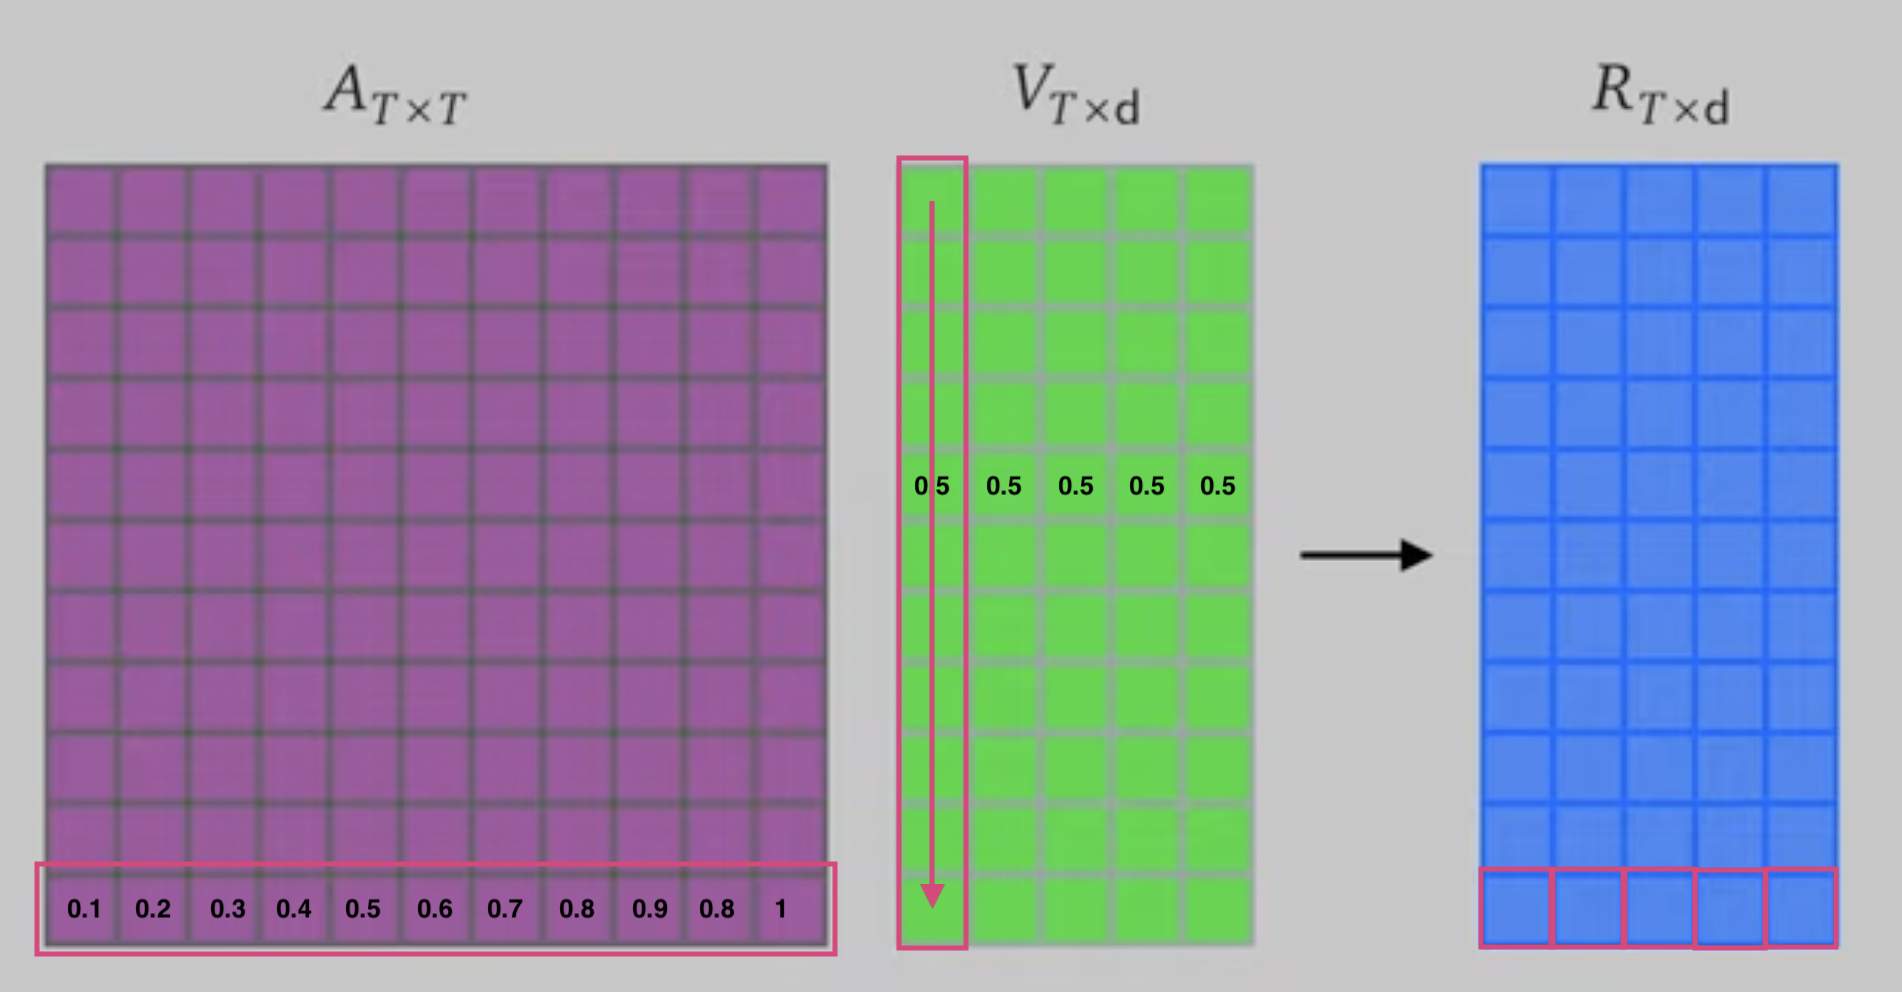

In [15]:
from IPython.display import Image
Image("./attention2.png")

Now let's start filling in the Memory part

In [12]:
# What we want to do before applying Wo is the below, and even BEFORE restoring the embedding_dim over the heads.
# This is because each attn head has its own memory (even though they are all sharing the same memory in the vid's implementation)
# So essentially we want to do the below for each attn head (which means we need num_attn_head of these gates):

# head_mem_context_vectors = (mem_context_vectors * gate) + (head_context_vectors * (1 - gate))

# The means mem_context_vector needs to also have dim (b_s, num_attn_heads, seq_len, head_dim) aka (b, h, s, d) and gate needs to add
# these up in the final (d) dimension.

# Now for Memory the input are queries and the outputs (our inputs) are the retrieved memories:

# Some fake queries:
queries = torch.randn(b_s, num_attn_heads, seq_len, head_dim) # -> Memory expects (b_s, seq_len, mem_dim), once per attn head

top_k = 3

queries = rearrange(queries, 'b h s d -> b s (h d)') # This basically restores the queries to how they come in in forward()
# This already implies that mem_dim is embed_dim

# mem_keys_and_valyes = mem.query(queries, top_k)
# Let's use fake memories for now:
# Memory query returns (b_s, seq_len, top_k, 2, mem_dim), so the below implies mem_dim == embed_dim
mem_keys_and_values = torch.randn(b_s, seq_len, top_k, 2, num_attn_heads * head_dim)

mem_keys, mem_values = mem_keys_and_values.unbind(-2) # Unbind on the '2'

# Even though the memories are embed_dim, we add them at the level of the attn head, so we need to split them. The idea is that 
# each head can learn to use the memory or not and to what extent.
# But essentially the memory gets 'cut up' as well.

mem_keys = rearrange(mem_keys, 'b s k (h d) -> b h s k d', h = num_attn_heads)
mem_values = rearrange(mem_values, 'b s k (h d) -> b h s k d', h = num_attn_heads)

# We calculate attn scores per head as in a normal head, but the keys are the keys from memory.

# In order to do this, we need to break up the queries again over the attn heads (optimize, this is inverse of the above):
queries = rearrange(queries, 'b s (h d) -> b h s d', h=num_attn_heads)

# The "normal" code for calculating attn scores is: attn_scores = einsum(queries, keys, 'b h s1 d, b h s2 d -> b h s1 s2')
# So you might be tempted to do this:
# attn_scores = einsum(queries, mem_keys, 'b h s1 d, b h s2 k d -> b h s1 s2 k')
# However, the seq_len x seq_len matrix is because we want to measure the resonance of each token with each token, starting with
# the first token, for training optimization (parallellization).
# Here we are just interested in the resonance of each token id IN THE FULL SEQUENCE (last sequence in the otherwise maksed matrix)
# with each of the three memories (keys). So it becomes:

attn_scores = einsum(queries, mem_keys, 'b h s d, b h s k d -> b h s k')
# We essentially end up with 3 dot products per token id in the sequence.

attn_scores = attn_scores * (head_dim ** -0.5)

# Normally here we do causal masking, but we can look at the whole memories as they are memories (keys) so no masking needed.

# Softmax as usual, be it on attn_scores instead of masked_attn_scores:
# Softmax here is just to scale them all between 0 and 1, so we can apply it to the last dimension here as well.

import torch.nn.functional as F
attn_weights = F.softmax(attn_scores, dim = -1)      # This is (b h s k)


#head_context_vectors -> mem_context_vectors
mem_context_vectors = einsum(attn_weights, mem_values, 'b h s k, b h s k d -> b h s d')
# Each index in the k dim contains a weight. We multiply that weight with each vector in the d dim and then add up all the result vectors.

# Ok now let's get back to: # head_mem_context_vectors = (mem_context_vectors * gate) + (head_context_vectors * (1 - gate))
# We need a learnable gate per head:

gate = nn.Parameter(torch.randn(num_attn_heads, 1, 1)) # This has requires_grad set to True
# Check broadcast rules: writing it like this makes for correct broadcasting to all vectors (size d) i.e. to each vector in the sequence (s).


head_mem_context_vectors = (mem_context_vectors * gate) + (head_context_vectors * (1 - gate))
# Dim here is still (b h s d)

# From this point on we then continue with what's in forward() above, so:
#multihead_context_vector = rearrange(head_mem_context_vector, 'b h s d -> b s (h d)')
#multihead_context_vector = self.Wo(multihead_context_vector)
#return multihead_context_vector 


Next up: put it all in a class!

In [3]:
# The below is a version where we "cut up" the embed_dim over the attn heads, rather than projecting it.

import torch.nn.functional as F
import torch.nn as nn

class MHSelfAttnWithMem(nn.Module):

    def __init__(self, embed_dim, num_attn_heads=8, head_dim=32, top_k=3):
        super().__init__()

        # Need these in forward()
        self.num_attn_heads = num_attn_heads
        self.top_k = top_k

        self.Wq = nn.Linear(embed_dim, num_attn_heads * head_dim, bias=False)
        self.Wk = nn.Linear(embed_dim, num_attn_heads * head_dim, bias=False)
        self.Wv = nn.Linear(embed_dim, num_attn_heads * head_dim, bias=False)
        self.Wo = nn.Linear(num_attn_heads * head_dim, embed_dim) # Look up why Wo can hava a bias term

        self.gate = nn.Parameter(torch.randn(num_attn_heads, 1, 1))

    def forward(self, input_data, memory):    # input_data is (b_s, seq_len, embed_dim)

        b_s, seq_len = input_data.shape[:2]
        
        queries = self.Wq(input_data)
        keys = self.Wk(input_data)
        values = self.Wv(input_data)
        
        queries = rearrange(queries, 'b_s seq_len (num_attn_heads head_dim) -> b_s num_attn_heads seq_len head_dim', num_attn_heads=self.num_attn_heads)
        keys = rearrange(keys, 'b_s seq_len (num_attn_heads head_dim) -> b_s num_attn_heads seq_len head_dim', num_attn_heads=self.num_attn_heads)
        values = rearrange(values, 'b_s seq_len (num_attn_heads head_dim) -> b_s num_attn_heads seq_len head_dim', num_attn_heads=self.num_attn_heads)

        attn_scores = einsum(queries, keys, 'b h s1 d, b h s2 d -> b h s1 s2')

        i, j = attn_scores.shape[-2:]
        assert i == j, "Attention scores in attention head are not stored in a square matrix!"
        mask = torch.ones((attn_scores.shape[-1], attn_scores.shape[-1]), dtype=torch.bool).triu(diagonal=1)
        masked_attn_scores = attn_scores.masked_fill(mask, float("-inf"))

        attn_weights = F.softmax(masked_attn_scores, dim = -1)

        head_context_vectors = attn_weights@values
        
        # Up to this point this is all copied from forward() above, with some "self."'s added.
        # Adding the Memory part, so copying over from the part that comes after the forward(), with the exception that
        # we actually do consult the memory here.

        queries = rearrange(queries, 'b h s d -> b s (h d)')

        # Here we actually do consult the memory
        mem_keys_and_values = memory.query(queries, self.top_k)  # Returns (b_s, seq_len, top_k, 2, mem_dim) with mem_dim == embed_dim

        mem_keys, mem_values = mem_keys_and_values.unbind(-2)
        
        mem_keys = rearrange(mem_keys, 'b s k (h d) -> b h s k d', h = num_attn_heads)
        mem_values = rearrange(mem_values, 'b s k (h d) -> b h s k d', h = num_attn_heads)

        queries = rearrange(queries, 'b s (h d) -> b h s d', h=num_attn_heads)
        
        attn_scores = einsum(queries, mem_keys, 'b h s d, b h s k d -> b h s k')       
        attn_scores = attn_scores * (head_dim ** -0.5)

        attn_weights = F.softmax(attn_scores, dim = -1)
        
        # Extra: dropout
        attn_weights = self.dropout(attn_weigths)

        mem_context_vectors = einsum(attn_weights, mem_values, 'b h s k, b h s k d -> b h s d')

        # Just add "self."
        head_mem_context_vectors = (mem_context_vectors * self.gate) + (head_context_vectors * (1 - self.gate))
        
        multihead_context_vector = rearrange(head_mem_context_vector, 'b h s d -> b s (h d)')
        multihead_context_vector = self.Wo(multihead_context_vector)
        return multihead_context_vector
        